# Fitting 2D Epileptor model

In [1]:
import os
import sys
import time
import errno

import numpy as np
import scipy as scp
import scipy as scp
import matplotlib.pyplot as plt

import re
import pandas as pd
import seaborn as sns

In [2]:
from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import pystan

In [4]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [5]:
plt.style.use('seaborn-talk');

In [6]:
cwd = os.getcwd()
cwd

'/data/NumPyro'

## Centerized form of parameterization

In [7]:
! cat epileptor_ode_rk45_cen.stan

functions {
        
   real[] epileptor_ode(real t, real[] y, real[] params, real[] x_r, int[] x_i) {
 
   real eta;  
   real dydt[size(y)];
   eta = params[1];        
      
   dydt[1] = 1.0 - y[1]*y[1]*y[1] - 2.0*y[1]*y[1]- y[2] + x_r[1];
   dydt[2] = (1.0/x_r[2])*(4*(y[1] - eta) - y[2] );
                
   return dydt;
    }

}
    
    
data {
    int<lower=1> nt;  
    real t0;
    real Ts[nt];  
    real dt;
    real eta_true;    
    real x_init;
    real z_init;
    real xlim[2];
    real zlim[2];
    real I1;
    real tau0;
    vector[nt] xs;
}

transformed data {
    real x_r[2];
    int x_i[0];
    real obs[nt,1];

    real std=1.; 

    
    x_r[1]=I1 ;        
    x_r[2]=tau0; 
    
    for (t in 1:nt) {
        obs[t,1] =xs[t];
        }
       
}


parameters {
    real y0[2];
    real eta;  
    real <lower=0.0> amplitude;
    real offset; 
    real<lower=0.0> eps;
}


transformed parameters {
    real params[1];
    params[1] = eta;
}


model {
    real yhat[nt,2]

In [8]:
model=str('epileptor_ode_rk45_cen')

In [9]:
curr_dir=cwd

In [10]:
! cd /home/meysam/cmdstan && make $curr_dir/$model && cd $curr_dir


--- Translating Stan model to C++ code ---
bin/stanc  /data/NumPyro/epileptor_ode_rk45_cen.stan --o=/data/NumPyro/epileptor_ode_rk45_cen.hpp
Model name=epileptor_ode_rk45_cen_model
Input file=/data/NumPyro/epileptor_ode_rk45_cen.stan
Output file=/data/NumPyro/epileptor_ode_rk45_cen.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -O3 -march=native -mtune=native -DNO_FPRINTF_OUTPUT -pipe    -O3 -o /data/NumPyro/epileptor_ode_rk45_cen src/cmdstan/main.cpp -include /data/NumPyro/epileptor_ode_rk45_cen.hpp stan/lib/stan_math/lib/cvodes_2.9.0/lib/libsundials_nvecserial.a s

In [36]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=2000
warm_iter=2000

model=epileptor_ode_rk45_cen
data_input=data_input_epileptor_ode.R
data_output=data_output_${alg}_${model}

mkdir -p ${data_output}


for i in `seq 4`
do
    ./$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=data_input_files/${data_input}\
        output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> ${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [37]:
fit_foldername="data_output_hmc_"+model
fit_filename="output_hmc_"+model

In [38]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/NumPyro/data_output_hmc_epileptor_ode_rk45_cen'

In [39]:
! ls $dir_data_output

output_hmc_epileptor_ode_rk45_cen_1.csv
output_hmc_epileptor_ode_rk45_cen_1.out
output_hmc_epileptor_ode_rk45_cen_2.csv
output_hmc_epileptor_ode_rk45_cen_2.out
output_hmc_epileptor_ode_rk45_cen_3.csv
output_hmc_epileptor_ode_rk45_cen_3.out
output_hmc_epileptor_ode_rk45_cen_4.csv
output_hmc_epileptor_ode_rk45_cen_4.out


In [46]:
!tail -n2 $dir_data_output/*$model*out

==> /data/NumPyro/data_output_hmc_epileptor_ode_rk45_cen/output_hmc_epileptor_ode_rk45_cen_1.out <==
               10475.1 seconds (Total)


==> /data/NumPyro/data_output_hmc_epileptor_ode_rk45_cen/output_hmc_epileptor_ode_rk45_cen_2.out <==
               1462.15 seconds (Total)


==> /data/NumPyro/data_output_hmc_epileptor_ode_rk45_cen/output_hmc_epileptor_ode_rk45_cen_3.out <==
               5028.76 seconds (Total)


==> /data/NumPyro/data_output_hmc_epileptor_ode_rk45_cen/output_hmc_epileptor_ode_rk45_cen_4.out <==
               8597.04 seconds (Total)



In [53]:
chain=4

In [54]:
cvsfinemane='output_hmc_'+str(model)+'_'+str(chain)+'.csv'
cvsfinemane

'output_hmc_epileptor_ode_rk45_cen_4.csv'

Start of report!
Report directory: /data/NumPyro
------------------------------------------------------------
dynamic_type:  ode
------------------------------------------------------------
Report starts!
csv file directory: /data/NumPyro/data_output_hmc_epileptor_ode_rk45_cen/output_hmc_epileptor_ode_rk45_cen_4.csv
script_dir: /data/NumPyro
repor_filename: output_hmc_epileptor_ode_rk45_cen_4
------------------------------------------------------------
parameters and their shapes: 
lp__ (2000,)
accept_stat__ (2000,)
stepsize__ (2000,)
treedepth__ (2000,)
n_leapfrog__ (2000,)
divergent__ (2000,)
energy__ (2000,)
y0 (2000, 2)
eta (2000,)
amplitude (2000,)
offset (2000,)
eps (2000,)
params (2000, 1)
yhat (2000, 2, 1000)
x (2000, 1, 1000)
z (2000, 1, 1000)
xhat_q (2000, 1, 1000)
zhat_q (2000, 1, 1000)
x_ppc (2000, 1, 1000)
z_ppc (2000, 1, 1000)
log_lik (2000, 1, 1000)
------------------------------------------------------------
max_log_lik: -0.722018
---------------------------------------

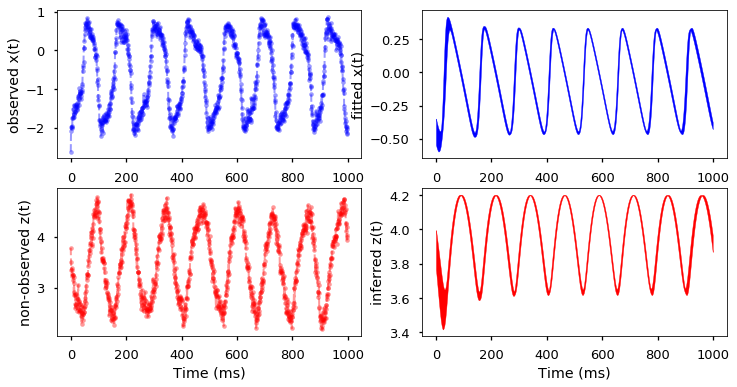

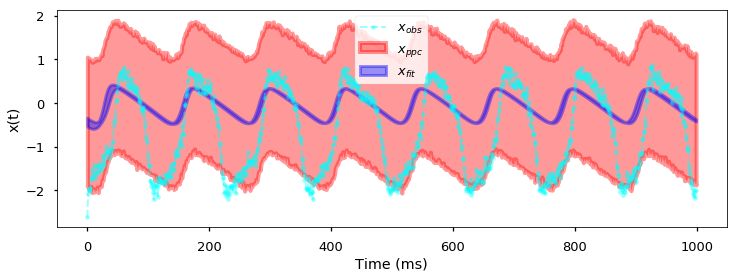

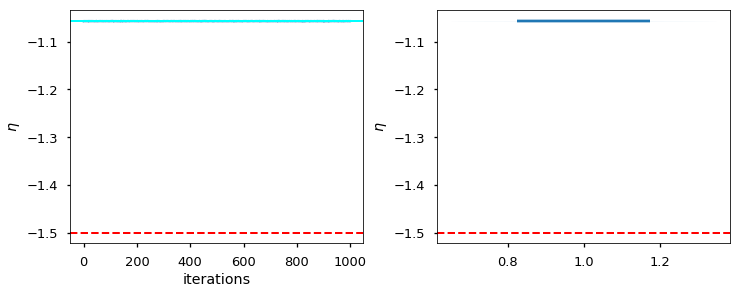

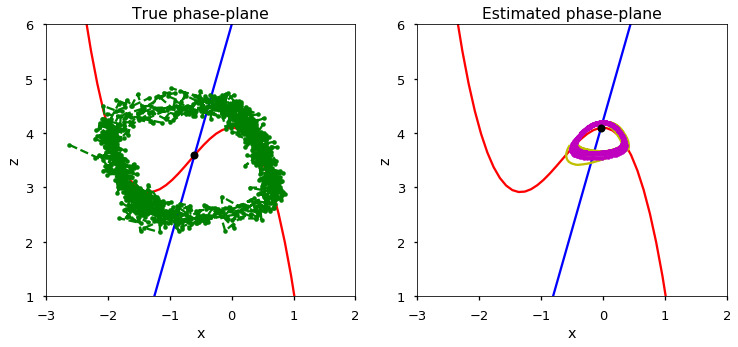

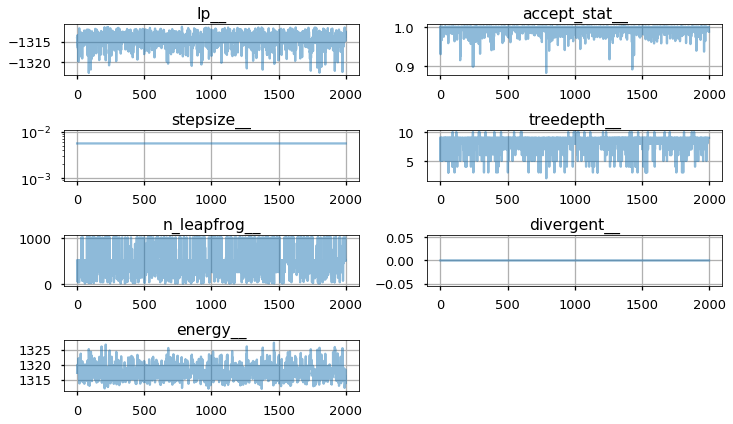

------------------------------------------------------------
End of report!
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------


In [55]:
run report_epileptor2D.py $dir_data_output/$cvsfinemane

In [56]:
diagname=model+'_hmc_diagnose_'+str(chain)+'.log'
summaryname=model+'_summary_'+str(chain)+'.csv'
diagname, summaryname

('epileptor_ode_rk45_cen_hmc_diagnose_4.log',
 'epileptor_ode_rk45_cen_summary_4.csv')

In [57]:
!/home/meysam/cmdstan/bin/diagnose  $dir_data_output/$cvsfinemane > $dir_data_output/$diagname
! cat $dir_data_output/$diagname

30 of 2000 (1.5%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps. Trajectories that are prematurely terminated due to this limit will result in slow exploration and you should increase the limit to ensure optimal performance.



In [58]:
%%capture
!/home/meysam/cmdstan/bin/stansummary --csv_file=$dir_data_output/$summaryname $dir_data_output/$cvsfinemane

In [59]:
from stan_utility import plot_rhat

filepath: /data/NumPyro/data_output_hmc_epileptor_ode_rk45_cen
filename: epileptor_ode_rk45_cen_summary_4
mycsvfile: /data/NumPyro/data_output_hmc_epileptor_ode_rk45_cen/epileptor_ode_rk45_cen_summary_4.csv
Normalized R= 1.0000816805817652
Rhat >1.1:  0.0


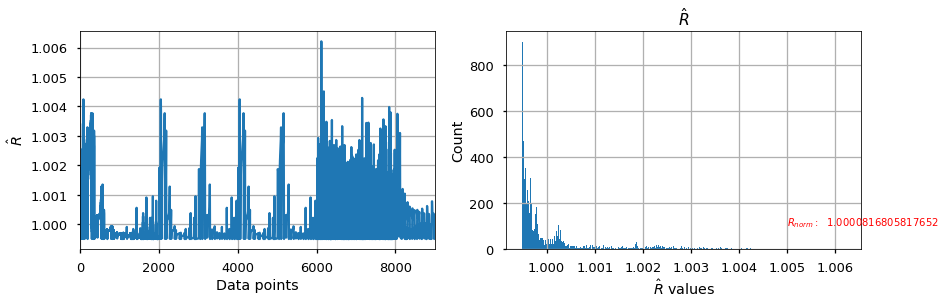

In [60]:
plot_rhat(dir_data_output, model+'_summary_'+str(chain))

## Noncenterized form of parameterization

In [61]:
! cat epileptor_ode_rk45_noncen.stan

functions {
        
   real[] epileptor_ode(real t, real[] y, real[] params, real[] x_r, int[] x_i) {
 
   real eta;  
   real dydt[size(y)];
   eta = params[1];        
      
   dydt[1] = 1.0 - y[1]*y[1]*y[1] - 2.0*y[1]*y[1]- y[2] + x_r[1];
   dydt[2] = (1.0/x_r[2])*(4*(y[1] - eta) - y[2] );
                
   return dydt;
    }

}
    
    
data {
    int<lower=1> nt;  
    real t0;
    real Ts[nt];  
    real dt;
    real eta_true;    
    real x_init;
    real z_init;
    real xlim[2];
    real zlim[2];
    real I1;
    real tau0;
    vector[nt] xs;
}

transformed data {
    real x_r[2];
    int x_i[0];
    real obs[nt,1];

    real std=1.;  
    
    x_r[1]=I1 ;        
    x_r[2]=tau0; 
    
    for (t in 1:nt) {
        obs[t,1] =xs[t];
        }
}


parameters {
    real x_init_star;
    real z_init_star;
    real eta_star;  
    real amplitude;
    real offset; 
    real<lower=0.0> eps;   
}


transformed parameters {
    real eta;
    real params[1];
    real y0[2];
    
 

In [62]:
model=str('epileptor_ode_rk45_noncen')

In [63]:
curr_dir=cwd

In [64]:
! cd /home/meysam/cmdstan && make $curr_dir/$model && cd $curr_dir


--- Translating Stan model to C++ code ---
bin/stanc  /data/NumPyro/epileptor_ode_rk45_noncen.stan --o=/data/NumPyro/epileptor_ode_rk45_noncen.hpp
Model name=epileptor_ode_rk45_noncen_model
Input file=/data/NumPyro/epileptor_ode_rk45_noncen.stan
Output file=/data/NumPyro/epileptor_ode_rk45_noncen.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -O3 -march=native -mtune=native -DNO_FPRINTF_OUTPUT -pipe    -O3 -o /data/NumPyro/epileptor_ode_rk45_noncen src/cmdstan/main.cpp -include /data/NumPyro/epileptor_ode_rk45_noncen.hpp stan/lib/stan_math/lib/cvodes_2.9.0/lib/libsu

In [69]:
%%bash

alg=hmc
adap_delta=0.99
max_depth=10
num_iter=2000
warm_iter=2000

model=epileptor_ode_rk45_noncen
data_input=data_input_epileptor_ode.R
data_output=data_output_${alg}_${model}

mkdir -p ${data_output}


for i in `seq 4`
do
    ./$model id=$i\
        sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
        adapt \
        delta=${adap_delta} \
        algorithm=${alg} \
        engine=nuts \
        max_depth=${max_depth}  \
        data file=data_input_files/${data_input}\
        output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
        &> ${data_output}/output_${alg}_${model}_$i.out &
done
#wait

In [70]:
fit_foldername="data_output_hmc_"+model
fit_filename="output_hmc_"+model

In [71]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/NumPyro/data_output_hmc_epileptor_ode_rk45_noncen'

In [72]:
! ls $dir_data_output

output_hmc_epileptor_ode_rk45_noncen_1.csv
output_hmc_epileptor_ode_rk45_noncen_1.out
output_hmc_epileptor_ode_rk45_noncen_2.csv
output_hmc_epileptor_ode_rk45_noncen_2.out
output_hmc_epileptor_ode_rk45_noncen_3.csv
output_hmc_epileptor_ode_rk45_noncen_3.out
output_hmc_epileptor_ode_rk45_noncen_4.csv
output_hmc_epileptor_ode_rk45_noncen_4.out


In [75]:
!tail -n2 $dir_data_output/*$model*out

==> /data/NumPyro/data_output_hmc_epileptor_ode_rk45_noncen/output_hmc_epileptor_ode_rk45_noncen_1.out <==
               11635.6 seconds (Total)


==> /data/NumPyro/data_output_hmc_epileptor_ode_rk45_noncen/output_hmc_epileptor_ode_rk45_noncen_2.out <==
               13101.8 seconds (Total)


==> /data/NumPyro/data_output_hmc_epileptor_ode_rk45_noncen/output_hmc_epileptor_ode_rk45_noncen_3.out <==
               14128.4 seconds (Total)


==> /data/NumPyro/data_output_hmc_epileptor_ode_rk45_noncen/output_hmc_epileptor_ode_rk45_noncen_4.out <==
               6072 seconds (Total)



In [86]:
chain=4

In [87]:
cvsfinemane='output_hmc_'+str(model)+'_'+str(chain)+'.csv'
cvsfinemane

'output_hmc_epileptor_ode_rk45_noncen_4.csv'

Start of report!
Report directory: /data/NumPyro
------------------------------------------------------------
dynamic_type:  ode
------------------------------------------------------------
Report starts!
csv file directory: /data/NumPyro/data_output_hmc_epileptor_ode_rk45_noncen/output_hmc_epileptor_ode_rk45_noncen_4.csv
script_dir: /data/NumPyro
repor_filename: output_hmc_epileptor_ode_rk45_noncen_4
------------------------------------------------------------
parameters and their shapes: 
lp__ (2000,)
accept_stat__ (2000,)
stepsize__ (2000,)
treedepth__ (2000,)
n_leapfrog__ (2000,)
divergent__ (2000,)
energy__ (2000,)
x_init_star (2000,)
z_init_star (2000,)
eta_star (2000,)
amplitude (2000,)
offset (2000,)
eps (2000,)
eta (2000,)
params (2000, 1)
y0 (2000, 2)
yhat (2000, 2, 1000)
x (2000, 1, 1000)
z (2000, 1, 1000)
xhat_q (2000, 1, 1000)
zhat_q (2000, 1, 1000)
x_ppc (2000, 1, 1000)
z_ppc (2000, 1, 1000)
log_lik (2000, 1, 1000)
---------------------------------------------------------

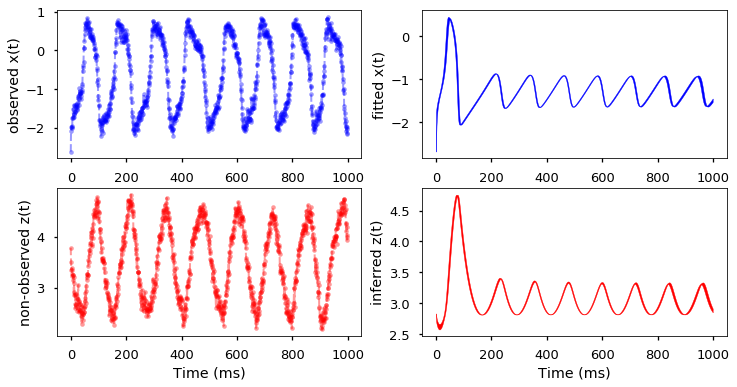

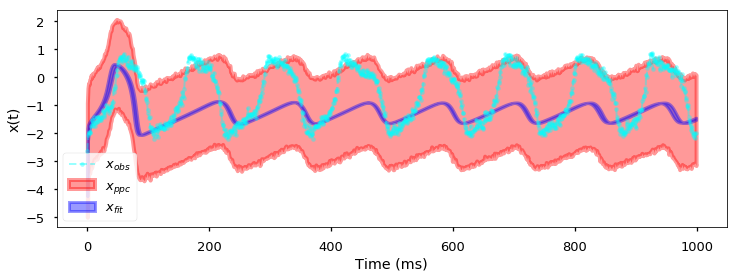

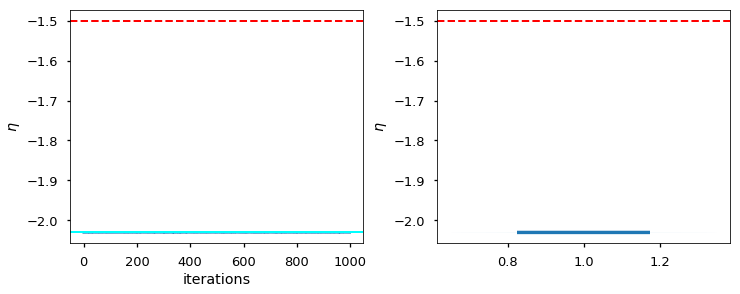

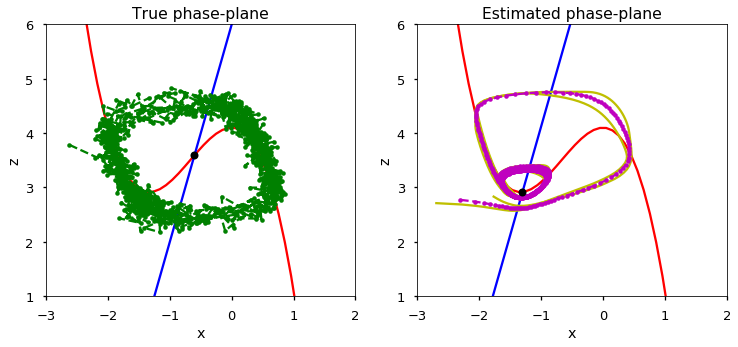

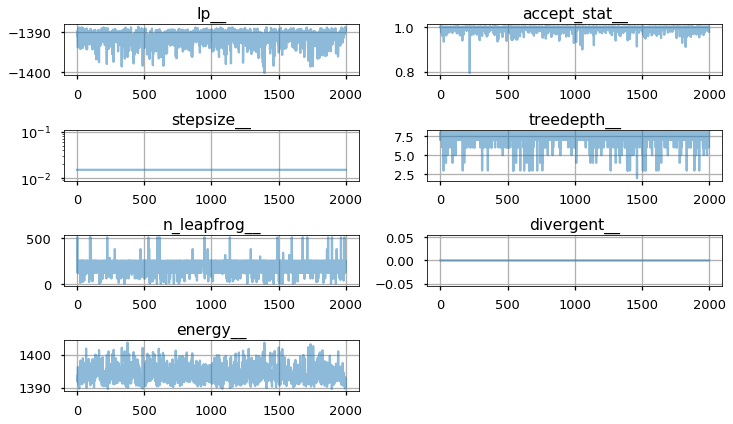

------------------------------------------------------------
End of report!
------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------


In [88]:
run report_epileptor2D.py $dir_data_output/$cvsfinemane

In [89]:
diagname=model+'_hmc_diagnose_'+str(chain)+'.log'
summaryname=model+'_summary_'+str(chain)+'.csv'
diagname, summaryname

('epileptor_ode_rk45_noncen_hmc_diagnose_4.log',
 'epileptor_ode_rk45_noncen_summary_4.csv')

In [90]:
!/home/meysam/cmdstan/bin/diagnose  $dir_data_output/$cvsfinemane > $dir_data_output/$diagname
! cat $dir_data_output/$diagname

In [91]:
%%capture
!/home/meysam/cmdstan/bin/stansummary --csv_file=$dir_data_output/$summaryname $dir_data_output/$cvsfinemane

In [92]:
from stan_utility import plot_rhat

filepath: /data/NumPyro/data_output_hmc_epileptor_ode_rk45_noncen
filename: epileptor_ode_rk45_noncen_summary_4
mycsvfile: /data/NumPyro/data_output_hmc_epileptor_ode_rk45_noncen/epileptor_ode_rk45_noncen_summary_4.csv
Normalized R= 1.0000106160932207
Rhat >1.1:  0.0


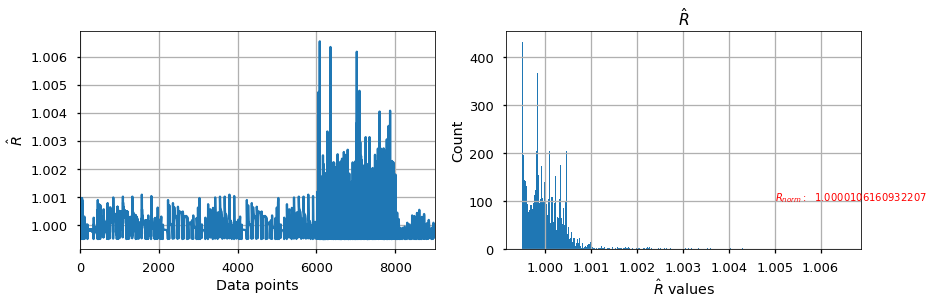

In [93]:
plot_rhat(dir_data_output, model+'_summary_'+str(chain))